In [1]:
# The libraries...

import os
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from  MDAnalysis.analysis.rms import RMSD
from MDAnalysis.analysis.dihedrals import Ramachandran
import mdtraj
from joblib import Parallel, delayed
import tqdm.auto as tqdm

/home/dm/miniconda3/envs/ice_ae/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib
/home/dm/miniconda3/envs/ice_ae/lib/python3.11/site-packages/MDAnalysis/analysis/data/filenames.py:110: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename


In [2]:
class Analysis:
    def __init__(self, traj_file, top = None, selection = "resid 0-19"):
        mdtraj_u = mdtraj.load(traj_file, top = top)
        self.mda_u = mda.Universe(top, traj_file)
        self.ids = self.mda_u.select_atoms(selection).indices
        self.sliced_mdtraj = mdtraj_u.atom_slice(self.ids)
        self.atomgroup = self.mda_u.select_atoms(selection, updating = True)
        self.mda_u.trajectory[0]
        self.ref = self.mda_u.select_atoms(selection)
        ######### including the time information..
        time = []
        for frame in self.mda_u.trajectory:
            time.append(frame.time)
        self.time = time

    def RMSD(self, selection = "name CA"):
        """
        Returns the RMSD of the protein form refference structure
        """
        protein = self.atomgroup
        ref = self.ref
        R = RMSD(protein, ref, select = selection)
        R.run()
        return R.results.rmsd[:,2]

    def ROG(self):
        """
        Returns radius of gyration of the protein 
        """
        polymer = self.atomgroup
        #u.trajectory[0]
        #ref = u.select_atoms("resid 1-20")
        rog_list = []
        for frame in self.mda_u.trajectory:
            rog_list.append(polymer.radius_of_gyration())
        return np.array(rog_list, dtype = np.float32)

    def SASA(self):
        """
        Returns a 1D array of sasa value of the protein
        """
        sasa = mdtraj.shrake_rupley(self.sliced_mdtraj)
        return sasa.sum(axis = 1)
    
    def ramachandran(self):
        """
        Returns a 2D array, 1st column phi, 2nd column psi
        """
        r = Ramachandran(self.atomgroup).run()
        return r.results.angles

In [3]:
top = "/home/dm/Dropbox/Family Room/Dibyendu_conf/Trp-Cage/respawn_0.gro"
path = "/home/dm/Dropbox/Family Room/Dibyendu_conf/Trp-Cage/"
xtc = os.listdir("/home/dm/Dropbox/Family Room/Dibyendu_conf/Trp-Cage/")
xtc_files = []
for file in xtc:
    if file.endswith("xtc"):
        xtc_files.append(file)

In [4]:
# For one trajectory..
ana = Analysis(path+xtc_files[1], top = top)

/home/dm/miniconda3/envs/ice_ae/lib/python3.11/site-packages/MDAnalysis/analysis/dihedrals.py:407: UserWarning: Cannot determine phi and psi angles for the first or last residues
  warnings.warn("Cannot determine phi and psi angles for the first "


Text(0, 0.5, '$\\psi$')

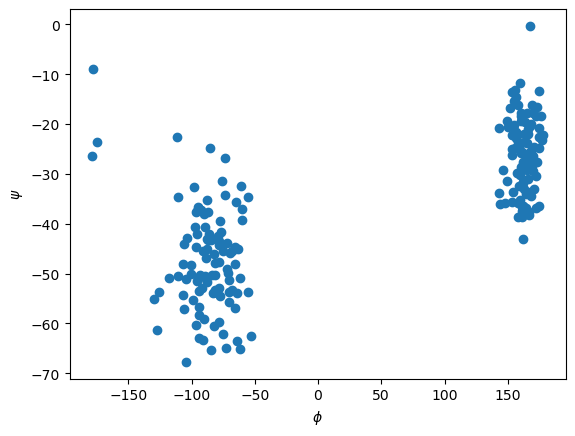

In [5]:
# Ramachandran analysis..
rama = ana.ramachandran()
plt.scatter(rama[:,0], rama[:,1])
plt.xlabel(r"$\phi$")
plt.ylabel(r"$\psi$")


Text(0, 0.5, 'RMSD($\\AA$)')

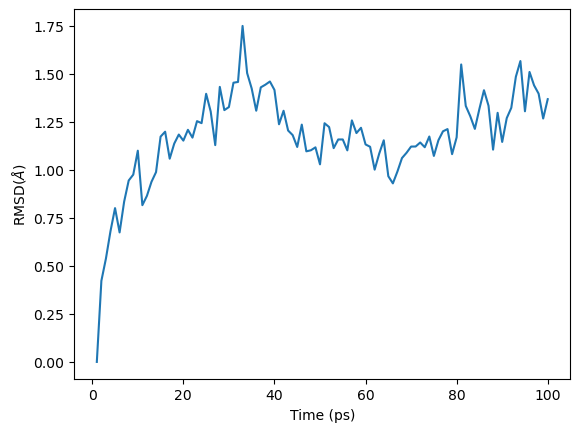

In [6]:
# RMSD analysis..
rmsd = ana.RMSD()
plt.plot(ana.time, rmsd)
plt.xlabel(r"Time (ps)")
plt.ylabel(r"RMSD($\AA$)")

Text(0, 0.5, '$R_g(\\AA)$')

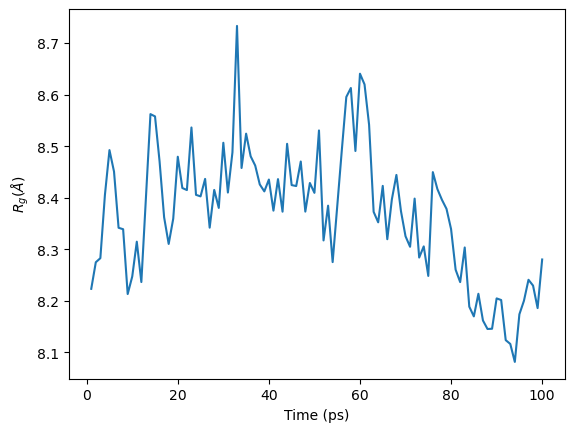

In [7]:
# ROG analysis..
rog = ana.ROG()
plt.plot(ana.time, rog)
plt.xlabel(r"Time (ps)")
plt.ylabel(r"$R_g(\AA)$")

Text(0, 0.5, 'SASA')

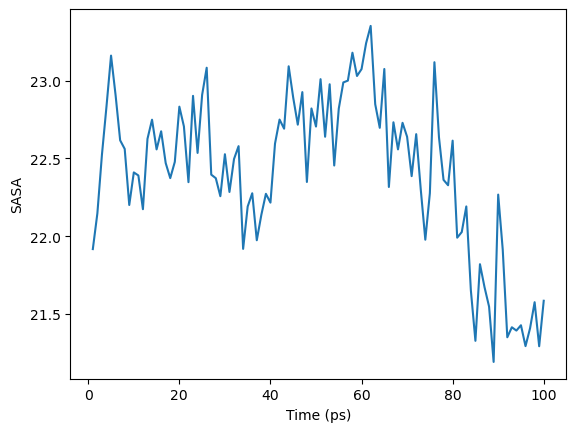

In [8]:
# ROG analysis..
sasa = ana.SASA()
plt.plot(ana.time, sasa)
plt.xlabel(r"Time (ps)")
plt.ylabel(r"SASA")

In [10]:
class Decision:
    def __init__(self):
        pass
    def slope_n_intercept(self, x, y):
        m,c = np.polyfit(x, y , deg = 1)
        return m, c 
    def decideRMSD(self, time, rmsd):
        m, c = self.slope_n_intercept(time, rmsd)
    def decideROG(self, time, rog):
        m, c = self.slope_n_intercept(time, rog)
        if abs(m) < 0.1:
            print("Not changing much")
        if m < 0:
            "Rg is decreasing.. means"
        elif m > 0:
            "Rg is increasing.. means"
    def decisionSASA(self, time, sasa):
        pass
